## Test Geneva Dataset Suitability

Script evaluate suitability of the chosen dataset for the task. It

- downloads the Geneva dataset from Hugging Face,

- parses the grid/neighbourhood id from filenames,

- trains a quick baseline segmenter on source grids,

- evaluates 0-shot IoU per grid on held-out splits (val/test),

- prints a table so you can pick a “target neighbourhood” that really causes a performance drop.

This is the cleanest way to answer “is this neighbourhood different enough?”: train once, then compare IoU across grids.

In [4]:
# --- Install deps ---
# Run this in a notebook cell (or install once in your env):
!pip install -q "huggingface_hub[cli]" pillow torchvision torch

import os, random
from pathlib import Path
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from huggingface_hub import snapshot_download
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

# -----------------------
# Repro + device
# -----------------------
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


device: cpu


In [7]:
import os

# If Xet causes issues on your machine, disable it.
# IMPORTANT: set this before importing huggingface_hub
os.environ["HF_HUB_DISABLE_XET"] = "1"

from huggingface_hub import snapshot_download

DATA_DIR = "data/geneva"

root = snapshot_download(
    repo_id="raphaelattias/overfitteam-geneva-satellite-images",
    repo_type="dataset",
    local_dir=DATA_DIR,
    resume_download=True,
    max_workers=1,   # fewer requests -> fewer 429s
    token=True,      # uses your cached token from `huggingface-cli login`
)

print("dataset root:", root)


/Users/giocopp/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 2111 files:   0%|          | 0/2111 [00:00<?, ?it/s]

dataset root: /Users/giocopp/Desktop/Uni/Hertie School/5th Semester/DL/DL-FinalProject/DL-Tutorial-G1/data/geneva


In [10]:
# Pipeline 

CATEGORY = "all"  # or "industrial" or "residencial"

def grid_id_from_name(fname: str) -> str:
    # DOP25_LV03_1301_11_2015_1_15_497500.0_119062.5.png
    parts = fname.split("_")
    return f"{parts[2]}_{parts[3]}"

def mask_name_from_image_name(fname: str) -> str:
    return fname.replace(".png", "_label.png")

def load_mask(path):
    # Force 1 channel (L = grayscale)
    m = Image.open(path).convert("L")
    arr = np.array(m, dtype=np.uint8)  # [H,W]

    # Convert to binary {0,1}
    # (works whether mask uses 0/255 or arbitrary intensities)
    arr = (arr > 127).astype(np.uint8)

    return torch.from_numpy(arr).float().unsqueeze(0)  # [1,H,W]

def load_image(path):
    # Force 3 channels (RGB)
    im = Image.open(path).convert("RGB")
    arr = np.array(im, dtype=np.float32) / 255.0   # [H,W,3] in [0,1]
    x = torch.from_numpy(arr).permute(2, 0, 1)     # [3,H,W]
    return x

def collect_pairs(split: str, category: str):
    img_dir = os.path.join(root, split, "images", category)
    lab_dir = os.path.join(root, split, "labels", category)
    files = sorted([f for f in os.listdir(img_dir) if f.endswith(".png") and not f.endswith("_label.png")])
    pairs = []
    for f in files:
        g = grid_id_from_name(f)
        img_path = os.path.join(img_dir, f)
        lab_path = os.path.join(lab_dir, mask_name_from_image_name(f))
        if os.path.exists(lab_path):
            pairs.append((img_path, lab_path, g, split))
    return pairs

train_pairs = collect_pairs("train", CATEGORY)
val_pairs   = collect_pairs("val", CATEGORY)
test_pairs  = collect_pairs("test", CATEGORY)

all_grids = sorted(set([p[2] for p in (train_pairs + val_pairs + test_pairs)]))
print("grids found:", all_grids)

grids found: ['1301_11', '1301_13', '1301_31']


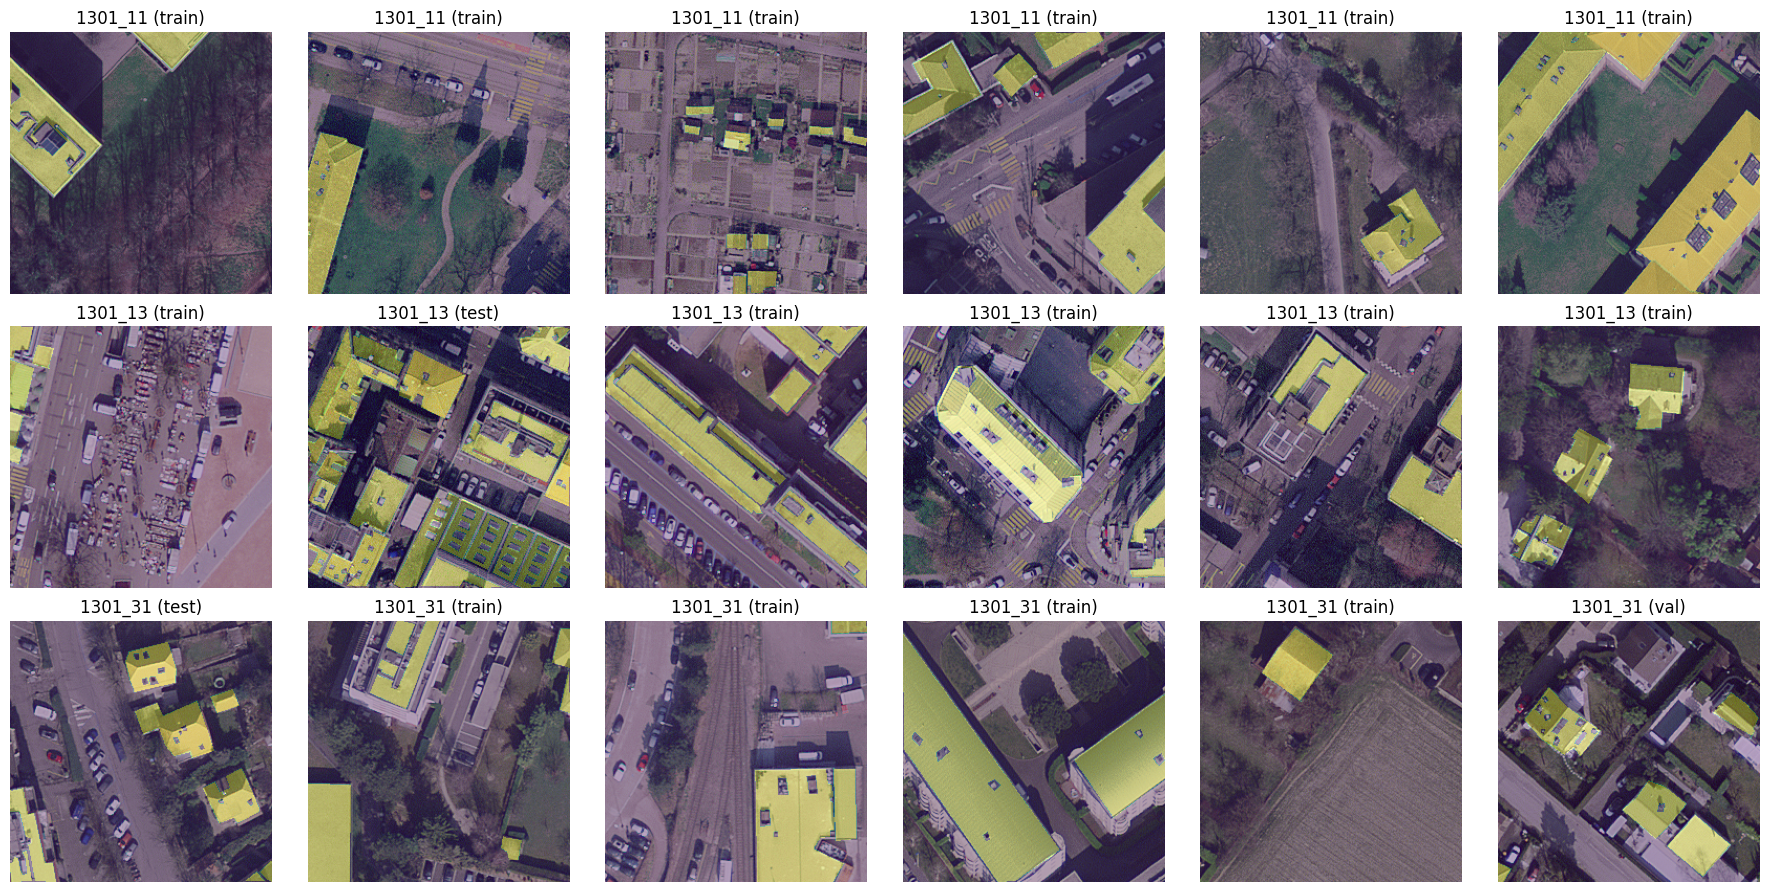

In [11]:
all_pairs = train_pairs + val_pairs + test_pairs
grids = sorted({g for *_, g, _ in all_pairs}) if len(all_pairs[0])==4 else sorted({p[2] for p in all_pairs})

def sample_pairs_for_grid(grid, n=6):
    items = [p for p in all_pairs if p[2] == grid]
    return random.sample(items, k=min(n, len(items)))

def show_grid_samples(n=6, seed=0):
    random.seed(seed)
    fig, axes = plt.subplots(len(grids), n, figsize=(3*n, 3*len(grids)))
    if len(grids) == 1:
        axes = np.expand_dims(axes, 0)

    for r, g in enumerate(grids):
        samples = sample_pairs_for_grid(g, n=n)
        for c, (img_path, mask_path, grid, split) in enumerate(samples):
            x = load_image(img_path)          # [3,H,W], float in [0,1]
            y = load_mask(mask_path)[0]       # [H,W], 0/1

            img = x.permute(1,2,0).numpy()
            axes[r, c].imshow(img)
            axes[r, c].imshow(y.numpy(), alpha=0.35)  # overlay mask
            axes[r, c].set_title(f"{g} ({split})")
            axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

show_grid_samples(n=6, seed=0)


In [13]:
from collections import Counter
import random

def majority_baseline(pairs):
    counts = Counter([p[2] for p in pairs])  # p[2] is grid
    total = sum(counts.values())
    maj_grid, maj_count = counts.most_common(1)[0]
    return counts, maj_grid, maj_count / total

def balanced_stratified_split(pairs, all_grids, n_per_grid=80, train_frac=0.8, seed=0):
    random.seed(seed)
    by_g = {g: [] for g in all_grids}
    for p in pairs:
        by_g[p[2]].append(p)

    min_n = min(len(by_g[g]) for g in all_grids)
    n_per_grid = min(n_per_grid, min_n)

    tr, te = [], []
    for g in all_grids:
        items = by_g[g][:]
        random.shuffle(items)
        items = items[:n_per_grid]
        cut = int(train_frac * len(items))
        tr += items[:cut]
        te += items[cut:]
    random.shuffle(tr); random.shuffle(te)
    return tr, te

# 1) split first
tr_pairs, te_pairs = balanced_stratified_split(train_pairs, all_grids, n_per_grid=80, seed=0)

print("train counts:", Counter([p[2] for p in tr_pairs]))
print("test counts: ", Counter([p[2] for p in te_pairs]))

# 2) baseline on the test split
counts, maj_grid, maj_acc = majority_baseline(te_pairs)
print("test counts:", counts)
print("majority grid:", maj_grid)
print("majority accuracy:", maj_acc)


train counts: Counter({'1301_11': 39, '1301_13': 39, '1301_31': 39})
test counts:  Counter({'1301_13': 10, '1301_31': 10, '1301_11': 10})
test counts: Counter({'1301_13': 10, '1301_31': 10, '1301_11': 10})
majority grid: 1301_13
majority accuracy: 0.3333333333333333


In [25]:
import os, random
from pathlib import Path
from collections import Counter

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

# -----------------------
# Config
# -----------------------
DATA_DIR = "data/geneva"     # your already-downloaded dataset folder
SPLIT = "train"             # use only train split for this diagnostic (as you did)
CATEGORY = "all"            # "all" / "industrial" / "residencial"

N_PER_GRID = 120            # balanced per-grid sample cap (auto-clipped)
TRAIN_FRAC = 0.8
BATCH_SIZE = 32

N_SPLITS = 10               # set to 5 or 10
EPOCHS = 30
LR = 1e-3
BASE_SEED = 0

os.environ["HF_HUB_DISABLE_XET"] = "1"  # harmless locally; can help some setups


# -----------------------
# Helpers: dataset indexing
# -----------------------
def grid_id_from_name(fname: str) -> str:
    parts = fname.split("_")
    return f"{parts[2]}_{parts[3]}"

def mask_name_from_image_name(fname: str) -> str:
    return fname.replace(".png", "_label.png")

def collect_pairs(root: str, split: str, category: str):
    img_dir = os.path.join(root, split, "images", category)
    lab_dir = os.path.join(root, split, "labels", category)

    files = sorted(
        f for f in os.listdir(img_dir)
        if f.endswith(".png") and not f.endswith("_label.png")
    )
    pairs = []
    for f in files:
        g = grid_id_from_name(f)
        img_path = os.path.join(img_dir, f)
        lab_path = os.path.join(lab_dir, mask_name_from_image_name(f))
        if os.path.exists(lab_path):
            pairs.append((img_path, lab_path, g, split))
    return pairs

class ImgOnlyDS(Dataset):
    def __init__(self, pairs, preprocess):
        self.pairs = pairs
        self.preprocess = preprocess

    def __len__(self): return len(self.pairs)

    def __getitem__(self, i):
        img_path, _, grid, _ = self.pairs[i]
        pil = Image.open(img_path).convert("RGB")
        x = self.preprocess(pil)  # ImageNet normalization etc.
        return x, grid


# -----------------------
# Step 1: Load pairs
# -----------------------
root = str(Path(DATA_DIR).resolve())
pairs = collect_pairs(root, SPLIT, CATEGORY)
assert len(pairs) > 0, "No pairs found. Check DATA_DIR / SPLIT / CATEGORY."
grids = sorted({p[2] for p in pairs})
print("N pairs:", len(pairs))
print("Grids:", grids)

# Balanced sizes possible
by_g = {g: [] for g in grids}
for idx, p in enumerate(pairs):
    by_g[p[2]].append(idx)
min_n = min(len(by_g[g]) for g in grids)
n = min(N_PER_GRID, min_n)
print("Per-grid available:", {g: len(by_g[g]) for g in grids})
print("Using n_per_grid =", n)


# -----------------------
# Step 2: Extract frozen features ONCE
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

weights = FCN_ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

model = fcn_resnet50(weights=weights).to(device)
backbone = model.backbone.to(device)
backbone.eval()

@torch.no_grad()
def extract_all_features(pairs):
    dl = DataLoader(ImgOnlyDS(pairs, preprocess), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    X = []
    g_list = []
    for x, g in dl:
        x = x.to(device)
        out = backbone(x)
        fmap = out["out"] if isinstance(out, dict) else out   # [B,C,H,W]
        vec = fmap.mean(dim=(2,3))                            # [B,C]
        X.append(vec.cpu())
        g_list.extend(list(g))
    X = torch.cat(X, dim=0)  # [N,C]
    return X, g_list

X_all, grid_list = extract_all_features(pairs)
grid_to_id = {g:i for i,g in enumerate(grids)}
y_all = torch.tensor([grid_to_id[g] for g in grid_list], dtype=torch.long)
k = len(grids)

print("Feature matrix:", tuple(X_all.shape), "| labels:", tuple(y_all.shape))

N pairs: 420
Grids: ['1301_11', '1301_13', '1301_31']
Per-grid available: {'1301_11': 295, '1301_13': 76, '1301_31': 49}
Using n_per_grid = 49
device: cpu
Feature matrix: (420, 2048) | labels: (420,)


In [26]:
import numpy as np
import torch

# --- helpers ---
def stratified_folds(y, n_splits=5, seed=0):
    """Return list of index arrays, one per fold (stratified by class)."""
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    folds = [[] for _ in range(n_splits)]
    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        rng.shuffle(idx)
        for i, j in enumerate(idx):
            folds[i % n_splits].append(int(j))
    return [np.array(f, dtype=int) for f in folds]

def confusion_matrix_np(y_true, y_pred, k):
    cm = np.zeros((k, k), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def balanced_accuracy_from_cm(cm):
    per = []
    for i in range(cm.shape[0]):
        denom = cm[i].sum()
        per.append((cm[i, i] / denom) if denom > 0 else 0.0)
    return float(np.mean(per))

@torch.no_grad()
def ridge_predict(Xtr, ytr, Xte, k, reg=1.0):
    """
    Deterministic linear classifier via ridge regression on one-hot labels.
    X*: torch float on CPU, shapes [N,D]
    y*: torch long on CPU, shape [N]
    """
    Xtr = Xtr.float()
    Xte = Xte.float()

    # add bias term
    Xtrb = torch.cat([Xtr, torch.ones((Xtr.shape[0], 1))], dim=1)  # [N,D+1]
    Xteb = torch.cat([Xte, torch.ones((Xte.shape[0], 1))], dim=1)

    Y = torch.zeros((Xtrb.shape[0], k), dtype=torch.float32)
    Y[torch.arange(Xtrb.shape[0]), ytr] = 1.0

    Dp1 = Xtrb.shape[1]
    A = Xtrb.T @ Xtrb + reg * torch.eye(Dp1)
    B = Xtrb.T @ Y
    W = torch.linalg.solve(A, B)           # [D+1, k]
    logits = Xteb @ W                      # [M, k]
    return logits.argmax(dim=1)            # [M]

# --- K-fold evaluation (out-of-fold) ---
def kfold_eval(X_all, y_all, k, n_splits=5, seed=0, reg=1.0):
    X_all = X_all.cpu()
    y_all = y_all.cpu().long()

    folds = stratified_folds(y_all.numpy(), n_splits=n_splits, seed=seed)

    fold_acc, fold_bacc = [], []
    oof_pred = np.full(len(y_all), -1, dtype=int)

    for fi, te_idx in enumerate(folds, 1):
        tr_mask = np.ones(len(y_all), dtype=bool)
        tr_mask[te_idx] = False
        tr_idx = np.where(tr_mask)[0]

        pred = ridge_predict(X_all[tr_idx], y_all[tr_idx], X_all[te_idx], k=k, reg=reg).numpy()
        oof_pred[te_idx] = pred

        true = y_all[te_idx].numpy()
        acc = float((pred == true).mean())

        cm = confusion_matrix_np(true, pred, k)
        bacc = balanced_accuracy_from_cm(cm)

        fold_acc.append(acc)
        fold_bacc.append(bacc)
        print(f"fold {fi:02d}/{n_splits} | acc={acc:.3f} | bacc={bacc:.3f}")

    # overall out-of-fold metrics (uses ALL samples)
    y_true = y_all.numpy()
    overall_acc = float((oof_pred == y_true).mean())
    overall_cm = confusion_matrix_np(y_true, oof_pred, k)
    overall_bacc = balanced_accuracy_from_cm(overall_cm)

    fold_acc = np.array(fold_acc, dtype=float)
    fold_bacc = np.array(fold_bacc, dtype=float)

    print("\nPer-fold summary:")
    print(f"acc  mean±std:  {fold_acc.mean():.3f} ± {fold_acc.std(ddof=1):.3f}")
    print(f"bacc mean±std:  {fold_bacc.mean():.3f} ± {fold_bacc.std(ddof=1):.3f}")

    print("\nOut-of-fold (all samples) metrics:")
    print(f"OOF acc:  {overall_acc:.3f}")
    print(f"OOF bacc: {overall_bacc:.3f}")
    print("OOF confusion matrix (rows=true, cols=pred):\n", overall_cm)

    return {
        "fold_acc": fold_acc, "fold_bacc": fold_bacc,
        "oof_acc": overall_acc, "oof_bacc": overall_bacc,
        "oof_cm": overall_cm
    }

# Run it (try 5-fold, then 10-fold)
res5 = kfold_eval(X_all, y_all, k=len(grids), n_splits=5, seed=0, reg=1.0)


fold 01/5 | acc=0.835 | bacc=0.649
fold 02/5 | acc=0.821 | bacc=0.666
fold 03/5 | acc=0.833 | bacc=0.661
fold 04/5 | acc=0.845 | bacc=0.689
fold 05/5 | acc=0.855 | bacc=0.722

Per-fold summary:
acc  mean±std:  0.838 ± 0.013
bacc mean±std:  0.677 ± 0.029

Out-of-fold (all samples) metrics:
OOF acc:  0.838
OOF bacc: 0.676
OOF confusion matrix (rows=true, cols=pred):
 [[283   8   4]
 [ 23  47   6]
 [ 20   7  22]]


In [27]:
def repeated_kfold(X_all, y_all, k, n_splits=5, seeds=range(10), reg=1.0):
    oof_accs, oof_baccs = [], []
    for sd in seeds:
        print("\n" + "="*20, "seed", sd, "="*20)
        res = kfold_eval(X_all, y_all, k=k, n_splits=n_splits, seed=sd, reg=reg)
        oof_accs.append(res["oof_acc"])
        oof_baccs.append(res["oof_bacc"])

    oof_accs = np.array(oof_accs, dtype=float)
    oof_baccs = np.array(oof_baccs, dtype=float)

    print("\n==== Summary over seeds (OOF metrics) ====")
    print(f"OOF acc  mean±std:  {oof_accs.mean():.3f} ± {oof_accs.std(ddof=1):.3f}")
    print(f"OOF bacc mean±std:  {oof_baccs.mean():.3f} ± {oof_baccs.std(ddof=1):.3f}")
    return oof_accs, oof_baccs

# 10-fold repeated 10 times
oof_accs, oof_baccs = repeated_kfold(X_all, y_all, k=len(grids), n_splits=10, seeds=range(10), reg=1.0)



==================== seed 0 ====================
fold 01/10 | acc=0.837 | bacc=0.633
fold 02/10 | acc=0.791 | bacc=0.611
fold 03/10 | acc=0.837 | bacc=0.750
fold 04/10 | acc=0.930 | bacc=0.906
fold 05/10 | acc=0.907 | bacc=0.864
fold 06/10 | acc=0.833 | bacc=0.664
fold 07/10 | acc=0.854 | bacc=0.693
fold 08/10 | acc=0.854 | bacc=0.638
fold 09/10 | acc=0.780 | bacc=0.531
fold 10/10 | acc=0.800 | bacc=0.548

Per-fold summary:
acc  mean±std:  0.842 ± 0.048
bacc mean±std:  0.684 ± 0.124

Out-of-fold (all samples) metrics:
OOF acc:  0.843
OOF bacc: 0.686
OOF confusion matrix (rows=true, cols=pred):
 [[284   7   4]
 [ 25  46   5]
 [ 18   7  24]]

==================== seed 1 ====================
fold 01/10 | acc=0.814 | bacc=0.678
fold 02/10 | acc=0.814 | bacc=0.628
fold 03/10 | acc=0.907 | bacc=0.808
fold 04/10 | acc=0.698 | bacc=0.506
fold 05/10 | acc=0.837 | bacc=0.608
fold 06/10 | acc=0.881 | bacc=0.717
fold 07/10 | acc=0.878 | bacc=0.760
fold 08/10 | acc=0.878 | bacc=0.705
fold 09/10 | 

We find evidence of grid-specific visual characteristics: a linear classifier trained on frozen FCN-ResNet50 features predicts the grid above chance (OOF balanced accuracy ≈ 0.69 vs 0.33 chance), indicating measurable distribution shifts across grids. Therefore, the Geneva dataset is suitable for testing cross-area generalization in rooftop segmentation